In [78]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize

In [79]:
def printattr(name, object):
    print(name)
h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_170_gev.h5', "r")
h5py_file.visititems(printattr)

event_features
event_features/mt
event_features/mx
jet_features
jet_features/barcode
jet_features/btag
jet_features/charge
jet_features/eta
jet_features/event
jet_features/mass
jet_features/num_of_jets
jet_features/phi
jet_features/pt
lepton_features
lepton_features/charge
lepton_features/eta
lepton_features/mass
lepton_features/phi
lepton_features/pid
lepton_features/pt
met_features
met_features/MET
met_features/eta
met_features/phi
met_features/sumet
neutrino_eta
neutrino_eta/spanet
neutrino_eta/target
parton_features
parton_features/eta
parton_features/masks
parton_features/mass
parton_features/parton_barcode
parton_features/pdgid
parton_features/phi
parton_features/pt
spanet
spanet/left_target
spanet/left_target/b
spanet/left_target/detection
spanet/left_target/mask
spanet/reconstructed_top_mass
spanet/right_target
spanet/right_target/b
spanet/right_target/detection
spanet/right_target/mask
spanet/right_target/q1
spanet/right_target/q2
target
target/left_target
target/left_target/b

In [80]:
# The reco_top_mss from ttbar_testing_mass_variation
mass = [170, 171, 172, 173, 174, 175, 176]
reco_dic = {}

for m in mass:
    h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_{}_gev.h5'.format(m), "r")
    cut = np.logical_and(h5py_file['spanet/reconstructed_top_mass'][:]>100, h5py_file['spanet/reconstructed_top_mass'][:]<300)
    reco_dic[m] = h5py_file['spanet/reconstructed_top_mass'][:][cut]

In [81]:
# Fixed the bins for all plots.
bins = np.arange(100, 301, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
tot_event = 100000

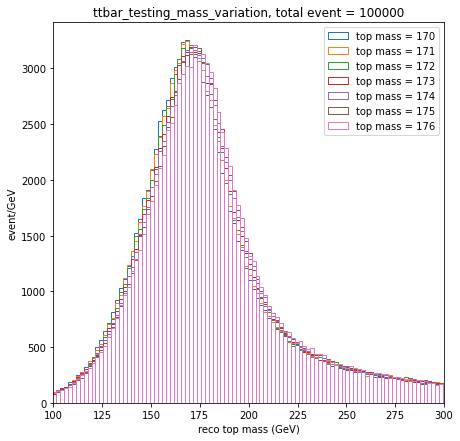

In [82]:
plt.figure(figsize=(7,7))
for i, m in enumerate(mass):
    hist, bin_edges = np.histogram(reco_dic[m], bins=bins)
    hist = hist*tot_event/sum(hist)
    plt.bar(bin_edges[:-1]+0.5, hist, edgecolor=colors[i], width=2, color='None', label = 'top mass = {}'.format(m))
plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
plt.xlim(100, 300)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')
plt.show()

In [83]:
# The total event is smaller than 100k, therefore I use only 10k.
reco_dic[173.0].shape

(237649,)

In [84]:
arr = []
# Generate 1000 times the sudo experiment
for i in range(1000):
    reco = np.random.choice(reco_dic[173.0], size=tot_event, replace=False)
    hist, bin_edges = np.histogram(reco, bins=bins)
    arr.append(hist)
arr = np.array(arr)

In [85]:
# Calculate the mean and the std for the event.
mean = np.mean(arr, axis=0)
std = np.std(arr, axis=0)

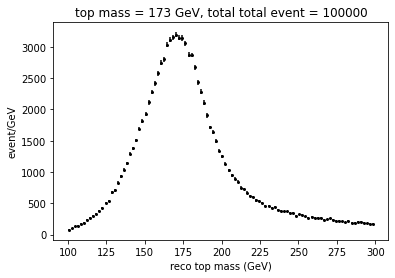

In [86]:
plt.errorbar(bins[:-1]+0.5, mean, c='k', yerr=std, fmt="o", markersize=2)
plt.title('top mass = 173 GeV, total total event = {}'.format(tot_event))
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.show()

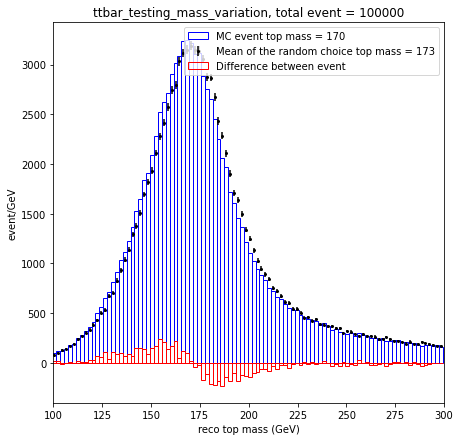

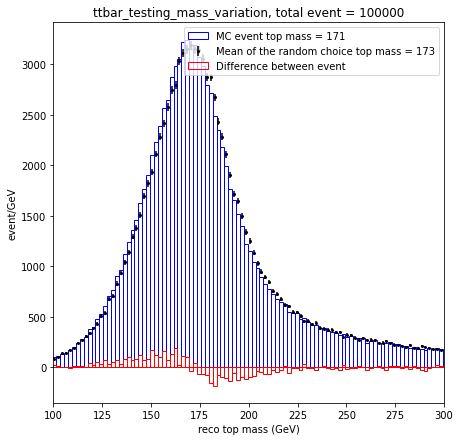

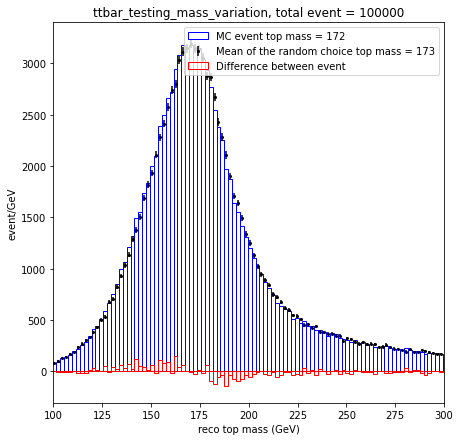

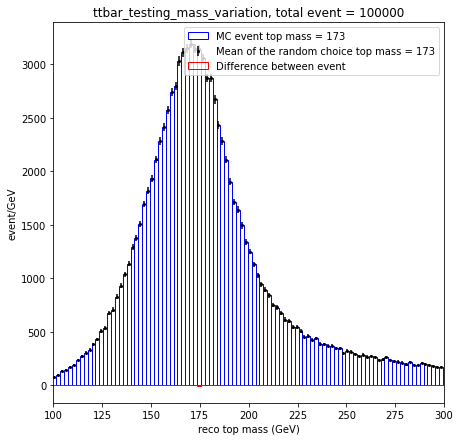

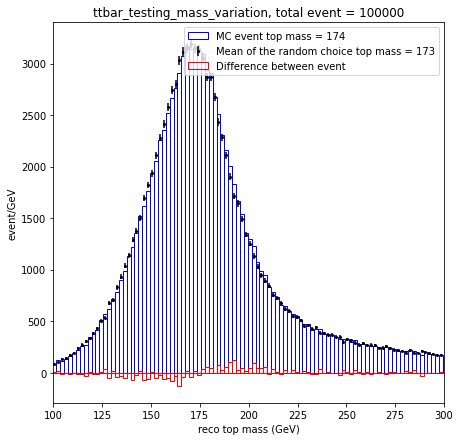

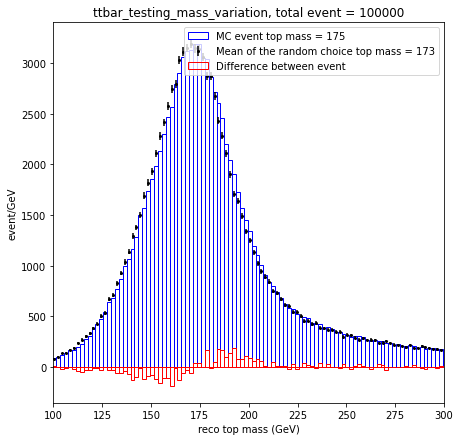

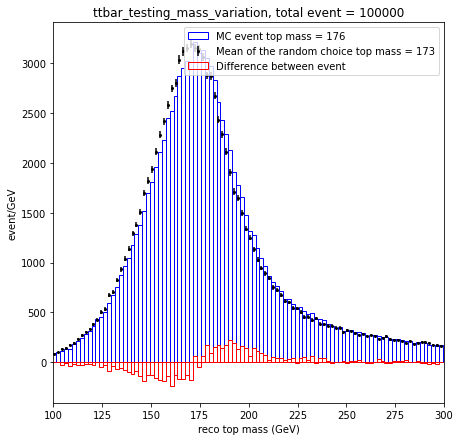

In [87]:
for i, m in enumerate(mass):
    plt.figure(figsize=(7,7))
    hist, bin_edges = np.histogram(reco_dic[m], bins=bins)
    hist = hist*tot_event/sum(hist)
    plt.bar(bin_edges[:-1]+0.5, hist, edgecolor='blue', width=2, color='None', label = 'MC event top mass = {}'.format(m))
    plt.errorbar(bins[:-1]+0.5, mean, c='k', yerr=std, fmt="o", markersize=2, label = 'Mean of the random choice top mass = 173')
    plt.bar(bin_edges[:-1]+0.5, hist-mean, edgecolor='red', width=2, color='None', label = 'Difference between event')
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
    plt.show()

In [88]:
def chi2(mt1, mt2): #mt1 is the observation, mt2 is the expected
    n1, bins1 = np.histogram(mt1)
    n2, bins2 = np.histogram(mt2)
    n2 = n2*tot_event/sum(n2)
    chi2_value = 2*sum([n1[i] - n2[i] + n2[i]*np.log(n2[i]/n1[i]) for i in range(len(n1))])
    return chi2_value

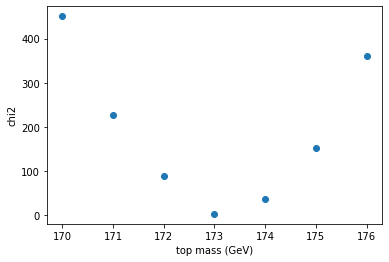

In [89]:
chi2_arr = [chi2(reco, reco_dic[m]) for m in mass]
plt.scatter(mass, chi2_arr)
plt.xlabel('top mass (GeV)')
plt.ylabel('chi2')
plt.show()

In [90]:
def porabola(x, a, b, c):
    return a*x**2 + b*x + c


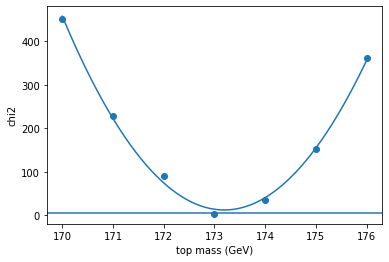

In [99]:
popt, pcov = optimize.curve_fit(porabola, mass, chi2_arr, method="lm")
x = np.linspace(170, 176, 1000)
y = porabola(x, popt[0], popt[1], popt[2])
plt.plot(x, y)
plt.axhline(min(chi2_arr)+1)
plt.scatter(mass, chi2_arr)
plt.xlabel('top mass (GeV)')
plt.ylabel('chi2')
plt.show()

In [91]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

In [92]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
def langau(x, lan_size, lan_loc, lan_scale, gau_size, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return lan_size*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + gau_size*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

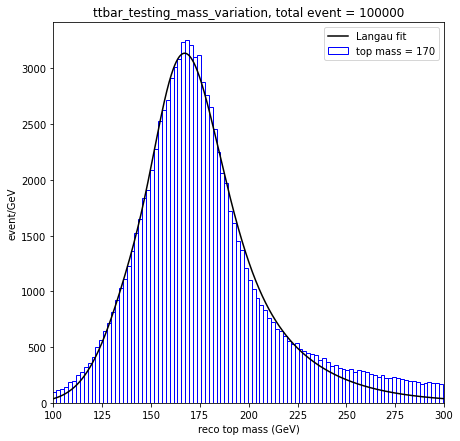

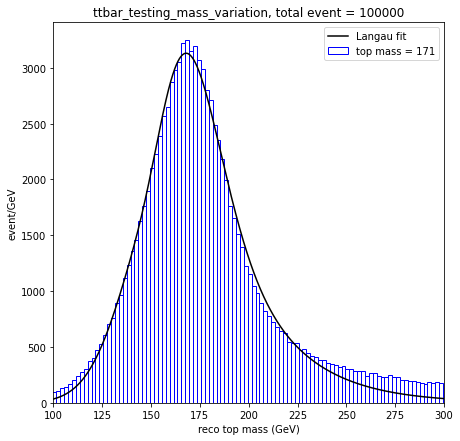

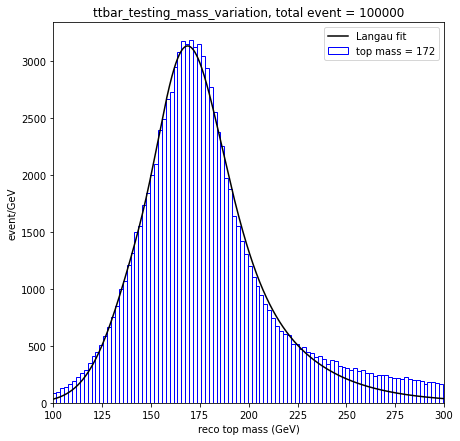

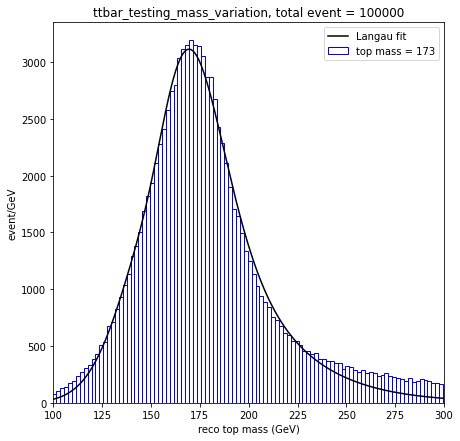

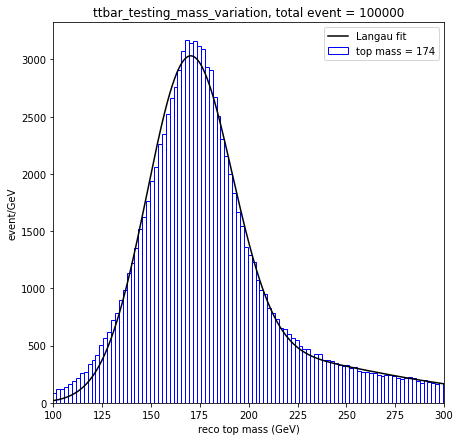

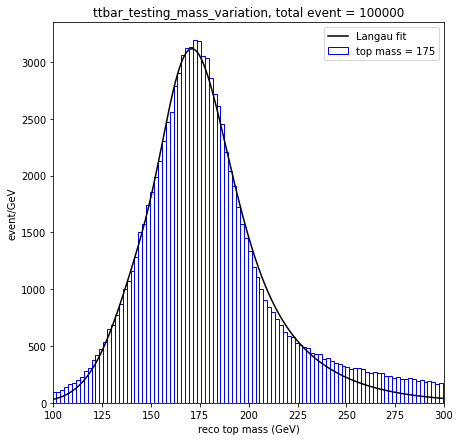

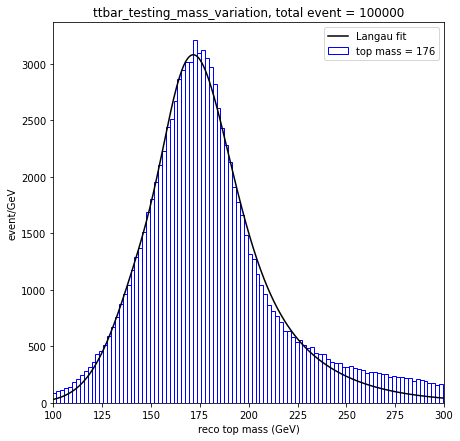

In [93]:
for i, m in enumerate(mass):
    plt.figure(figsize=(7,7))
    hist, bin_edges = np.histogram(reco_dic[m], bins=bins)
    hist = hist*tot_event/sum(hist)
    popt, pcov = optimize.curve_fit(langau, bin_edges[:-1]+0.5, hist,
                                    p0=(150, 1000, 1000, 150, 1000, 1000), method="lm")
    x = np.linspace(100, 300, 10000)
    y = langau(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
    plt.plot(x, y, c='k', label='Langau fit')
    plt.bar(bin_edges[:-1]+0.5, hist, edgecolor='blue', width=2, color='None', label = 'top mass = {}'.format(m))
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
    plt.show()

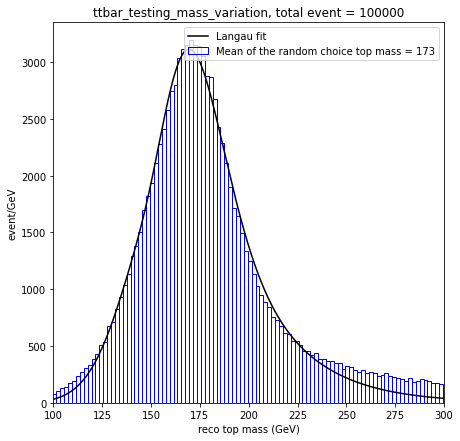

In [94]:
plt.figure(figsize=(7,7))
popt, pcov = optimize.curve_fit(langau, bin_edges[:-1]+0.5, mean,
                                p0=(150, 1000, 1000, 150, 1000, 1000), method="lm")
x = np.linspace(100, 300, 10000)
y = langau(x, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])
plt.plot(x, y, c='k', label='Langau fit')
plt.bar(bin_edges[:-1]+0.5, mean, edgecolor='blue', width=2, color='None', label = 'Mean of the random choice top mass = 173')
plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
plt.xlim(100, 300)
plt.xlabel('reco top mass (GeV)')
plt.ylabel('event/GeV')
plt.legend(loc='upper right')
plt.show()